In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv("/content/drive/MyDrive/TimeSeries/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep =';')

df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [4]:
feats = ['12', '13', '14']
df[feats].head(10)

,12,13,14
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1010.8,1010.8,1010.8
4,1061.5,1061.5,1061.5
5,1061.5,1061.5,1061.5
6,1061.5,1061.5,1061.5
7,1061.5,1061.5,1061.5
8,1064.1,1064.1,1064.1
9,966.7,966.7,966.7


##### 1. EDA

1.1 Kiểm tra dữ liệu thiếu

In [5]:
# Kiem tra dữ liệu thiếu
df[feats].isna().mean()

12    0.0
13    0.0
14    0.0
dtype: float64

  3 cột đều không có dữ liệu thiếu

1.2 Dùng biểu đồ headmap để kiểm tra độ tương quan của dữ kiệu

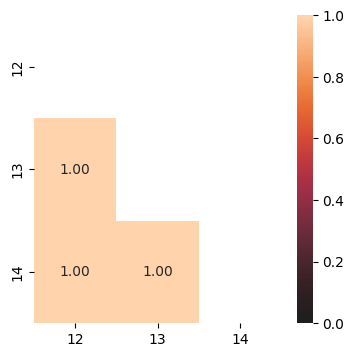

In [6]:
mask = np.triu(np.ones_like(df[feats].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df[feats].corr(), mask=mask, vmax=1, vmin=0, center=0,annot=True,fmt='.2f');

1.3 Dùng biểu đồ đường để biểu thị dữ liệu thời gian

In [7]:
import plotly.express as px
fig = px.line(y=df['12'], x=df['Ngày'])
fig.update_traces(line_color='red')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="Cột 12",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='#F5F5F5')

In [8]:
fig = px.line(y=df['13'], x=df['Ngày'])
fig.update_traces(line_color='red')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="Cột 13",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='#F5F5F5')

In [9]:
fig = px.line(y=df['14'], x=df['Ngày'])
fig.update_traces(line_color='red')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="Cột 14",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='#F5F5F5')

Scale dữ liệu

In [10]:
transformer = StandardScaler()

X = transformer.fit_transform(np.array(df[feats]))
df_scaled = pd.DataFrame(X, columns= feats)
print(df_scaled.head())

         12        13        14
0 -0.722947 -0.722956 -0.722984
1 -0.196295 -0.196303 -0.196326
2 -0.494382 -0.494391 -0.494416
3 -0.281054 -0.281063 -0.281086
4  0.201790  0.201782  0.201763


In [11]:
X[:10]

array([[-0.72294657, -0.72295646, -0.72298405],
       [-0.19629459, -0.19630298, -0.19632568],
       [-0.49438151, -0.49439075, -0.49441622],
       [-0.28105413, -0.28106276, -0.28108625],
       [ 0.20178954,  0.20178229,  0.20176329],
       [ 0.20178954,  0.20178229,  0.20176329],
       [ 0.20178954,  0.20178229,  0.20176329],
       [ 0.20178954,  0.20178229,  0.20176329],
       [ 0.22655076,  0.22654358,  0.22652481],
       [-0.70104242, -0.70105224, -0.70107964]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

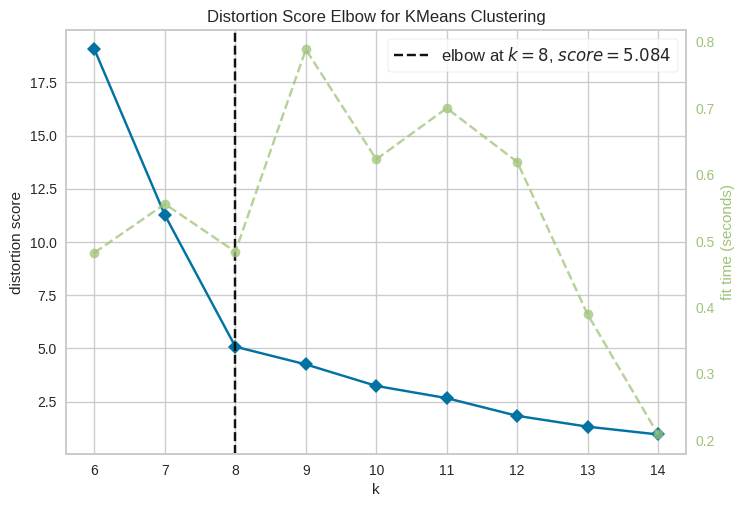

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(6,15))
Elbow_M.fit(X)
Elbow_M.show();

##### 2. Kalman

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



# Chuyển đổi cột "Ngày" sang định dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], dayfirst=True)

# Sắp xếp DataFrame theo ngày
df = df.sort_values('Ngày')

# Hàm áp dụng bộ lọc Kalman
def kalman_filter(data, A, H, Q, R, x0, P0):
    n = len(data)
    x_est = np.zeros(n)
    P = P0
    x = x0

    for t in range(n):
        # Prediction
        x = A * x
        P = A * P * A + Q

        # Measurement Update
        K = P * H / (H * P * H + R)
        x = x + K * (data[t] - H * x)
        P = (1 - K * H) * P

        x_est[t] = x

    return x_est

# Áp dụng bộ lọc Kalman cho từng cột
columns = ["12", "13", "14"]
for col in columns:
    data_column = df[col].values
    A = 1  # Ma trận chuyển tiếp
    H = 1  # Ma trận quan sát
    Q = 1e-5  # Hiệp phương sai chuyển tiếp
    R = 1e-1  # Hiệp phương sai quan sát
    x0 = data_column[0]  # Trạng thái ban đầu
    P0 = 1  # Hiệp phương sai trạng thái ban đầu

    filtered_data = kalman_filter(data_column, A, H, Q, R, x0, P0)
    df[col + "_Kalman"] = filtered_data

# Hiển thị dữ liệu sau khi áp dụng bộ lọc Kalman
df.head()


,Ngày,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,12_Kalman,13_Kalman,14_Kalman
0,2021-01-01,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.400000,964.400000,964.400000
31,2021-01-02,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.400000,964.400000,964.400000
59,2021-01-03,988.3,988.3,988.3,988.3,988.3,988.3,988.3,988.3,988.3,...,988.4,988.4,988.4,988.4,988.4,988.3,988.3,972.111077,972.111077,972.111077
90,2021-01-04,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,976.085462,976.085462,976.085462
120,2021-01-05,930.6,930.6,930.6,930.6,930.6,930.6,930.6,930.6,930.6,...,930.6,930.6,930.6,930.6,930.6,930.6,930.6,967.161140,967.161140,967.161140


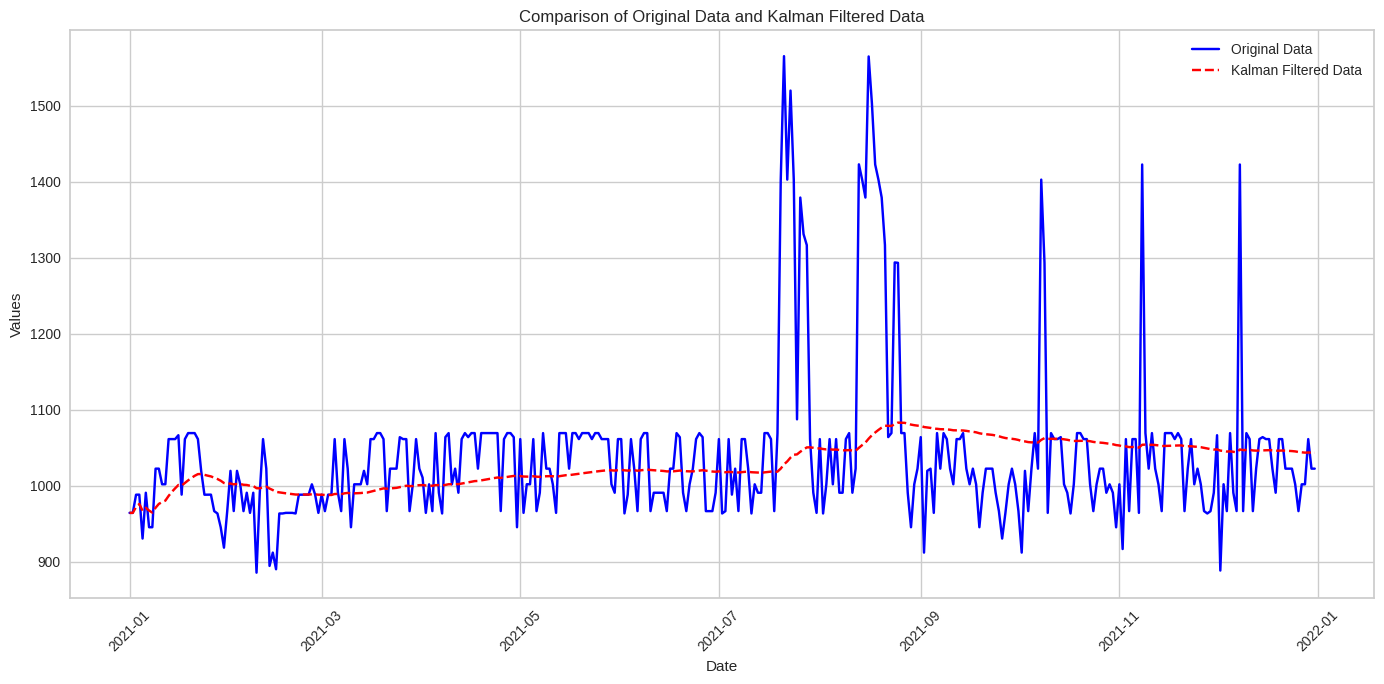

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Vẽ biểu đồ trước và sau khi áp dụng bộ lọc Kalman
plt.figure(figsize=(14, 7))
plt.plot(df['Ngày'], df['12'], label='Original Data', color='blue')
plt.plot(df['Ngày'], df['12_Kalman'], label='Kalman Filtered Data', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of Original Data and Kalman Filtered Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### 3.GRU

In [15]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import GRU

In [16]:
feats = ['Ngày', '12', '13', '14']

In [17]:
df = df[feats]

In [18]:
df

,Ngày,12,13,14
0,2021-01-01,964.4,964.4,964.4
31,2021-01-02,964.4,964.4,964.4
59,2021-01-03,988.3,988.3,988.3
90,2021-01-04,988.4,988.4,988.4
120,2021-01-05,930.6,930.6,930.6
...,...,...,...,...
360,2021-12-27,1002.0,1002.0,1002.1
361,2021-12-28,1002.0,1002.0,1002.0
362,2021-12-29,1061.5,1061.5,1061.5
363,2021-12-30,1022.6,1022.6,1022.6


Chuyển Fomat ngày

In [19]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-19-c0182c7af48c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-c0182c7af48c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tạo số dữ liệu bằng 12 tháng

In [20]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

Biểu đồ thể hiện training và test trước khi dữ đoán

In [21]:
import plotly.express as px
fig = px.line(y=df['12'], x=df['Ngày'])
fig.update_traces(line_color='Red')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="12",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='#F5F5F5')

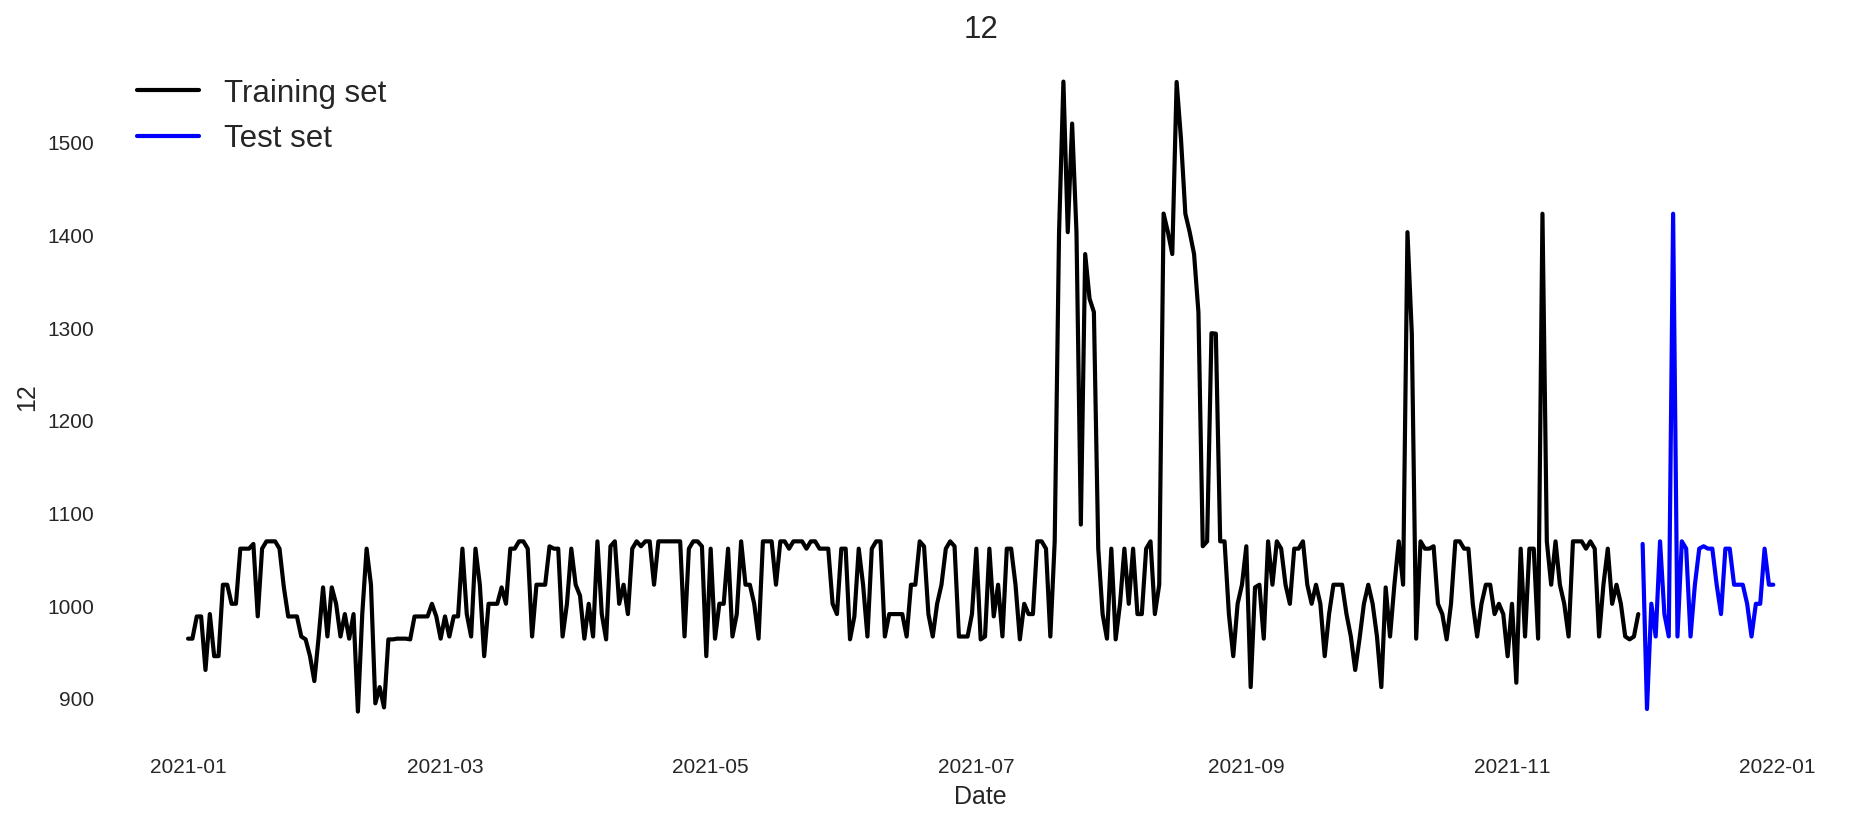

In [22]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['12'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['12'][-test_size:], color='blue', lw=2)
plt.title('12', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('12', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

Dùng MinmaxScaler đưa dữ liệu về khoảng 0-1

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['12']])

MinMaxScaler()

Chọn 10 ngày dự đoán cho 1 ngày tiếp theo

In [24]:
window_size = 10

Training data

In [25]:
train_data = df[['12']][:-test_size]
train_data = scaler.transform(train_data)

In [26]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

Test data

In [27]:
test_data = df[['12']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [28]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

Chuyển đổi dữ liệu từ dataframe, series sang numpy array

In [29]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [31]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


Khởi tạo model

In [32]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = GRU(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

Tạo bộ siêu tham số: epochs=30 (lặp 30 lần)

In [33]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14977 (58.50 KB)
Trainable params: 14977 (58.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 16s 231ms/step - loss: 0.0643 - val_loss: 0.0392
Epoch 2/50
10/10 [==============================] - 0s 3

Dự đoán

In [34]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [35]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [36]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.018432987853884697
Test MAPE: 1.7647571495206926


In [37]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

Biểu đồ sau khi dự đoán

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from current font.



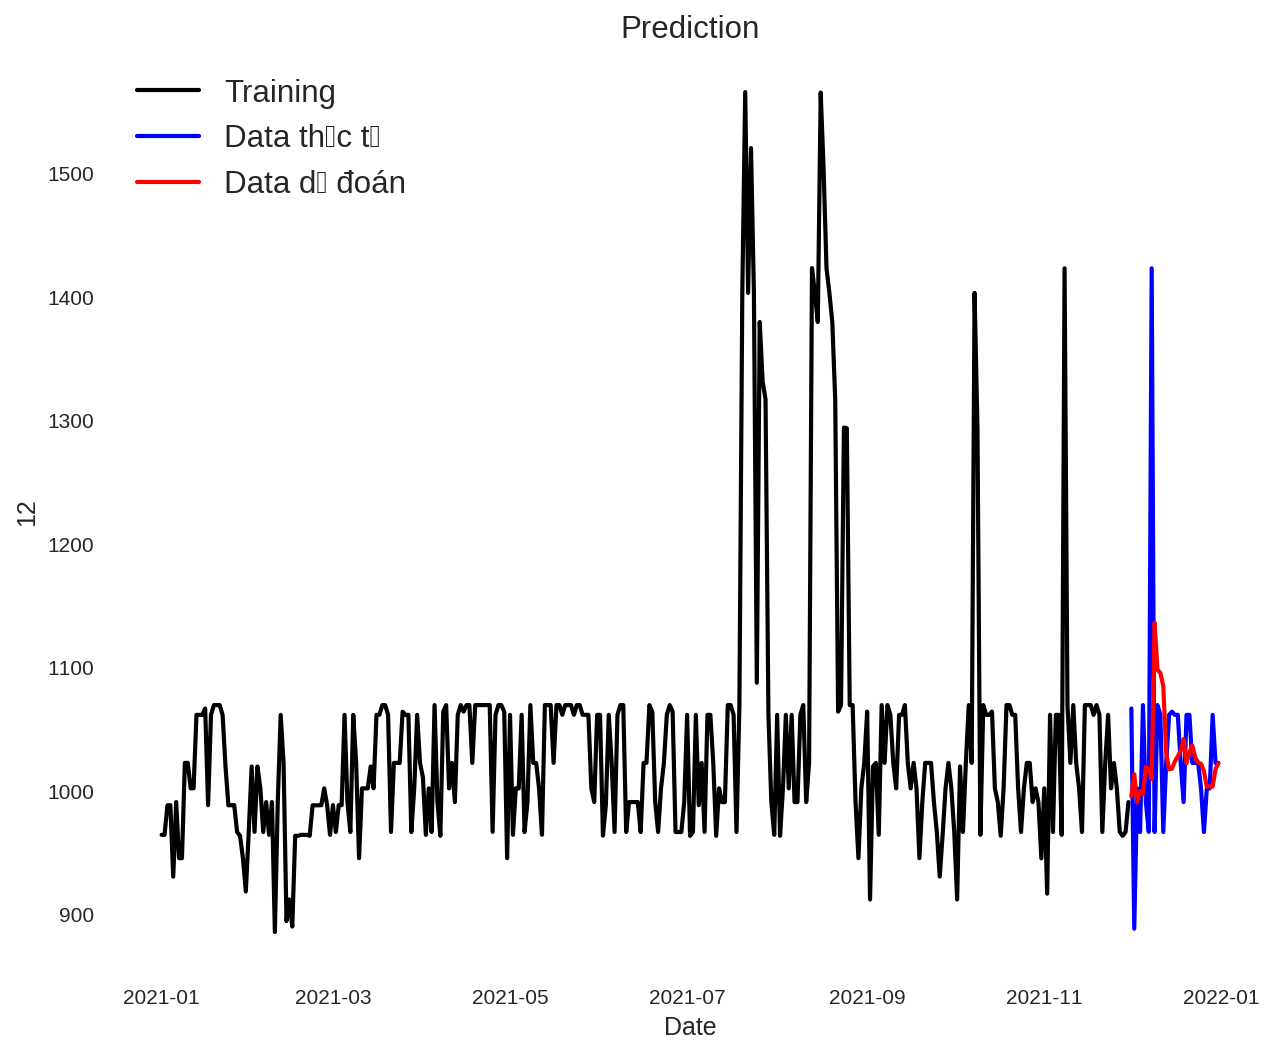

In [38]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('12', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()